# Transfer Learning with MobileNetV2

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation

Welcome to this week's assignment, where you'll be using transfer learning on a pre-trained CNN to build an Alpaca/Not Alpaca classifier!

 <center><img src="images/alpaca.png" style="width:300px;height:220px;"></center>

A pre-trained model is a network that's already been trained on a large dataset and saved, which allows you to use it to customize your own model cheaply and efficiently. The one you'll be using, MobileNetV2, was designed to provide fast and computationally efficient performance. It's been pre-trained on ImageNet, a dataset containing over 14 million images and 1000 classes.

By the end of this assignment, you will be able to:

- Create a dataset from a directory
- Preprocess and augment data using the Sequential API
- Adapt a pretrained model to new data and train a classifier using the Functional API and MobileNet
- Fine-tune a classifier's final layers to improve accuracy

## Important Note on Submission to the AutoGrader

Before submitting your assignment to the AutoGrader, please make sure you are not doing the following:

1. You have not added any _extra_ `print` statement(s) in the assignment.
2. You have not added any _extra_ code cell(s) in the assignment.
3. You have not changed any of the function parameters.
4. You are not using any global variables inside your graded exercises. Unless specifically instructed to do so, please refrain from it and use the local variables instead.
5. You are not changing the assignment code where it is not required, like creating _extra_ variables.

If you do any of the following, you will get something like, `Grader Error: Grader feedback not found` (or similarly unexpected) error upon submitting your assignment. Before asking for help/debugging the errors in your assignment, check for these first. If this is the case, and you don't remember the changes you have made, you can get a fresh copy of the assignment by following these [instructions](https://www.coursera.org/learn/convolutional-neural-networks/supplement/DS4yP/h-ow-to-refresh-your-workspace).

In [18]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "../datasets/alpacas/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.


Found 327 files belonging to 2 classes.
Using 65 files for validation.


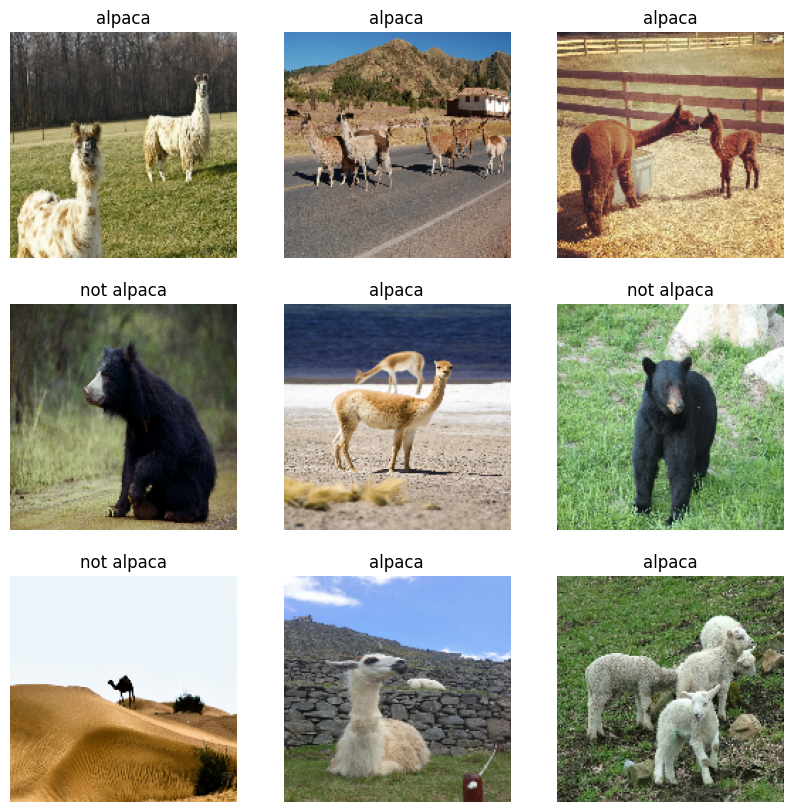

In [19]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<a name='2'></a>
## 2 - Preprocess and Augment Training Data

You may have encountered `dataset.prefetch` in a previous TensorFlow assignment, as an important extra step in data preprocessing. 

Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from your input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doesn't need to fit into memory.

You can set the number of elements to prefetch manually, or you can use `tf.data.experimental.AUTOTUNE` to choose the parameters automatically. Autotune prompts `tf.data` to tune that value dynamically at runtime, by tracking the time spent in each operation and feeding those times into an optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations. 

To increase diversity in the training set and help your model learn the data better, it's standard practice to augment the images by transforming them, i.e., randomly flipping and rotating them. Keras' Sequential API offers a straightforward method for these kinds of data augmentations, with built-in, customizable preprocessing layers. These layers are saved with the rest of your model and can be re-used later.  Ahh, so convenient! 

As always, you're invited to read the official docs, which you can find for data augmentation [here](https://www.tensorflow.org/tutorials/images/data_augmentation).


In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [21]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''

    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
        
    return data_augmentation

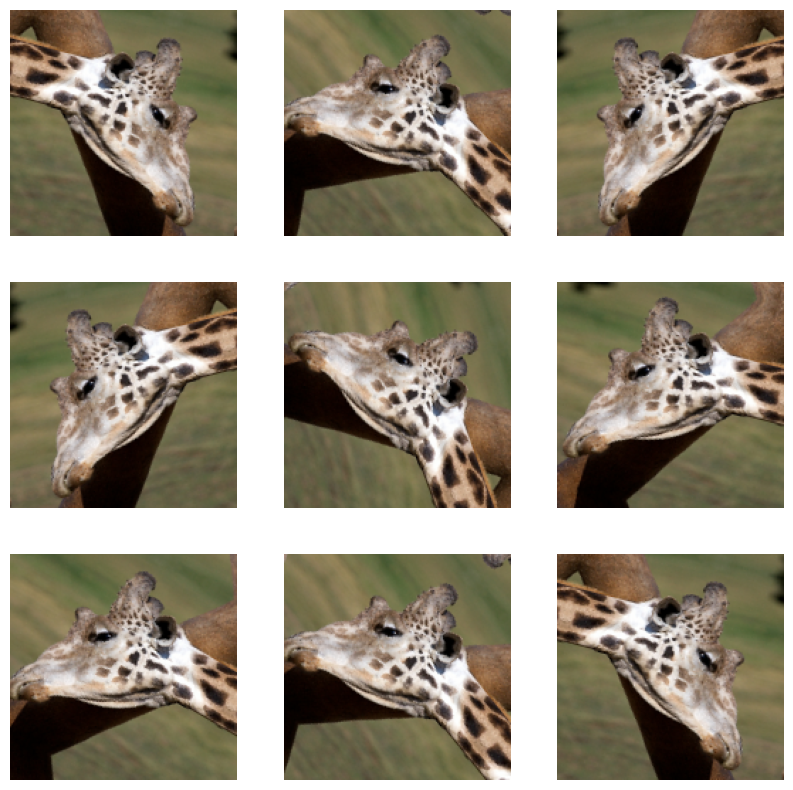

In [22]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Next, we'll apply our first tool from the MobileNet application in TensorFlow, to normalize your input. Since we're using a pre-trained model that was trained on the normalization values [-1,1], it's best practice to reuse that standard with tf.keras.applications.mobilenet_v2.preprocess_input.

**Conclusions:**

* When calling image_data_set_from_directory(), specify the train/val subsets and match the seeds to prevent overlap
* Use prefetch() to prevent memory bottlenecks when reading from disk
* Give your model more to learn from with simple data augmentations like rotation and flipping.
* When using a pretrained model, it's best to reuse the weights it was trained on.

In [23]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

<a name='3'></a>
## 3 - Using MobileNetV2 for Transfer Learning 

MobileNetV2 was trained on ImageNet and is optimized to run on mobile and other low-power applications. It's 155 layers deep (just in case you felt the urge to plot the model yourself, prepare for a long journey!) and very efficient for object detection and image segmentation tasks, as well as classification tasks like this one. The architecture has three defining characteristics:

*   Depthwise separable convolutions
*   Thin input and output bottlenecks between layers
*   Shortcut connections between bottleneck layers

<a name='3-1'></a>
### 3.1 - Inside a MobileNetV2 Convolutional Building Block

MobileNetV2 uses depthwise separable convolutions as efficient building blocks. Traditional convolutions are often very resource-intensive, and  depthwise separable convolutions are able to reduce the number of trainable parameters and operations and also speed up convolutions in two steps: 

1. The first step calculates an intermediate result by convolving on each of the channels independently. This is the depthwise convolution.

2. In the second step, another convolution merges the outputs of the previous step into one. This gets a single result from a single feature at a time, and then is applied to all the filters in the output layer. This is the pointwise convolution, or: **Shape of the depthwise convolution X Number of filters.**

<center><img src="images/mobilenetv2.png" style="width:650px;height:450px;"></center>
<caption><center> <u> <font color='purple'> <b>Figure 1</b> </u> : <b>MobileNetV2 Architecture</b> <br> This diagram was inspired by the original seen <a href="https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html#:~:text=MobileNetV2%20is%20a%20significant%20improvement,object%20detection%20and%20semantic%20segmentation.">here</a>.</font></center></caption>

Each block consists of an inverted residual structure with a bottleneck at each end. These bottlenecks encode the intermediate inputs and outputs in a low dimensional space, and prevent non-linearities from destroying important information. 

The shortcut connections, which are similar to the ones in traditional residual networks, serve the same purpose of speeding up training and improving predictions. These connections skip over the intermediate convolutions and connect the bottleneck layers. 

In [26]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

Note the last 2 layers here. They are the so called top layers, and they are responsible of the classification in the model

In [27]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d_1
predictions


Notice some of the layers in the summary like `Conv2D` and `DepthwiseConv2D` and how they follow the progression of expansion to depthwise convolution to projection. In combination with BatchNormalization and ReLU, these make up the bottleneck layers mentioned earlier.

**Conclusions**:

* MobileNetV2's unique features are: 
  * Depthwise separable convolutions that provide lightweight feature filtering and creation
  * Input and output bottlenecks that preserve important information on either end of the block
* Depthwise separable convolutions deal with both spatial and depth (number of channels) dimensions

Next, choose the first batch from the tensorflow dataset to use the images, and run it through the MobileNetV2 base model to test out the predictions on some of your images. 

In [28]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [29]:
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0])>

Now decode the predictions made by the model. Earlier, when you printed the shape of the batch, it would have returned (32, 1000). The number 32 refers to the batch size and 1000 refers to the 1000 classes the model was pretrained on. The predictions returned by the base model below follow this format:

First the class number, then a human-readable label, and last the probability of the image belonging to that class. You'll notice that there are two of these returned for each image in the batch - these the top two probabilities returned for that image.

In [30]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step


[[('n02489166', 'proboscis_monkey', 0.103299566),
  ('n02102177', 'Welsh_springer_spaniel', 0.078836136)],
 [('n02125311', 'cougar', 0.16546652), ('n02389026', 'sorrel', 0.10764299)],
 [('n02437312', 'Arabian_camel', 0.29232815),
  ('n02437616', 'llama', 0.2771356)],
 [('n03944341', 'pinwheel', 0.31154963), ('n03047690', 'clog', 0.052500404)],
 [('n02454379', 'armadillo', 0.7310722), ('n01990800', 'isopod', 0.038719807)],
 [('n02437312', 'Arabian_camel', 0.25663677),
  ('n02422106', 'hartebeest', 0.12122662)],
 [('n02437616', 'llama', 0.66125757),
  ('n02090721', 'Irish_wolfhound', 0.23782672)],
 [('n02133161', 'American_black_bear', 0.82735664),
  ('n02134418', 'sloth_bear', 0.029259581)],
 [('n01518878', 'ostrich', 0.9267561),
  ('n02002724', 'black_stork', 0.0017766313)],
 [('n01518878', 'ostrich', 0.9495456), ('n02018795', 'bustard', 0.002866168)],
 [('n02437616', 'llama', 0.86998457), ('n02412080', 'ram', 0.076756865)],
 [('n02415577', 'bighorn', 0.24294475), ('n02412080', 'ram', 

There's a whole lot of labels here, some of them hilariously wrong, but none of them say "alpaca."

This is because MobileNet pretrained over ImageNet doesn't have the correct labels for alpacas, so when you use the full model, all you get is a bunch of incorrectly classified images.

To solve this, we will delete the top layer, which contains all the classification labels, and create a new classification layer.

### Layer Freezing with the Functional API

<img src="images/snowalpaca.png" style="width:400px;height:250px;">

In the next sections, you'll see how you can use a pretrained model to modify the classifier task so that it's able to recognize alpacas. You can achieve this in three steps: 

1. Delete the top layer (the classification layer)
    * Set `include_top` in `base_model` as False
2. Add a new classifier layer
    * Train only one layer by freezing the rest of the network
    * As mentioned before, a single neuron is enough to solve a binary classification problem.
3. Freeze the base model and train the newly-created classifier layer
    * Set `base model.trainable=False` to avoid changing the weights and train *only* the new layer
    * Set training in `base_model` to False to avoid keeping track of statistics in the batch norm layer

In [ ]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    # include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tf.keras.layers.Dense(1, activation='linear')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [ ]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)